<a href="https://colab.research.google.com/github/1silvester/Computer_vision_emotion_recognition/blob/master/happy_house_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, h5py 
import cv2
import matplotlib.pyplot as plt 
from google.colab import files, drive
import numpy as np
import tensorflow as tf
import keras_preprocessing 
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
import matplotlib.image as matimg
from tensorflow.keras.models import load_model as ld_m
import seaborn as sns

In [ ]:
drive.mount('/content/gdrive')



Mounted at /content/gdrive


In [ ]:
root_path_train = 'gdrive/My Drive/final_project/happy_house_dataset/archive/train_happy.h5'
root_path_test = 'gdrive/My Drive/final_project/happy_house_dataset/archive/test_happy.h5'

In [ ]:
#boiler plate code https://www.kaggle.com/iarunava/happy-house-dataset
def load_happy_dataset(training_data_set, testing_data_set):
  train_data_set = h5py.File(root_path_train)
  data_x_axis = np.array(train_data_set['train_set_x'][:])
  data_y_axis = np.array(train_data_set['train_set_y'][:])

  test_data_set = h5py.File(root_path_test)
  test_data_x_axis = np.array(test_data_set['test_set_x'][:])
  test_data_y_axis = np.array(test_data_set['test_set_y'][:])

  print("before",tf.shape(data_y_axis).numpy())
  print("before",tf.shape(data_x_axis).numpy())
  print("before",tf.shape(test_data_y_axis).numpy())
  print("before",tf.shape(test_data_x_axis).numpy())

  data_y_axis = data_y_axis.reshape((1, data_x_axis.shape[0]))
  test_data_y_axis = test_data_y_axis.reshape(1, test_data_y_axis.shape[0])

  print("after ",tf.shape(data_y_axis).numpy())
  print("after ",tf.shape(data_x_axis).numpy())
  print("after ",tf.shape(test_data_y_axis).numpy())
  print("after ",tf.shape(test_data_x_axis).numpy())

  return data_x_axis, data_y_axis, test_data_x_axis, test_data_y_axis

In [ ]:
processed_data_set = load_happy_dataset(root_path_train, root_path_test)

before [600]
before [600  64  64   3]
before [150]
before [150  64  64   3]
after  [  1 600]
after  [600  64  64   3]
after  [  1 150]
after  [150  64  64   3]


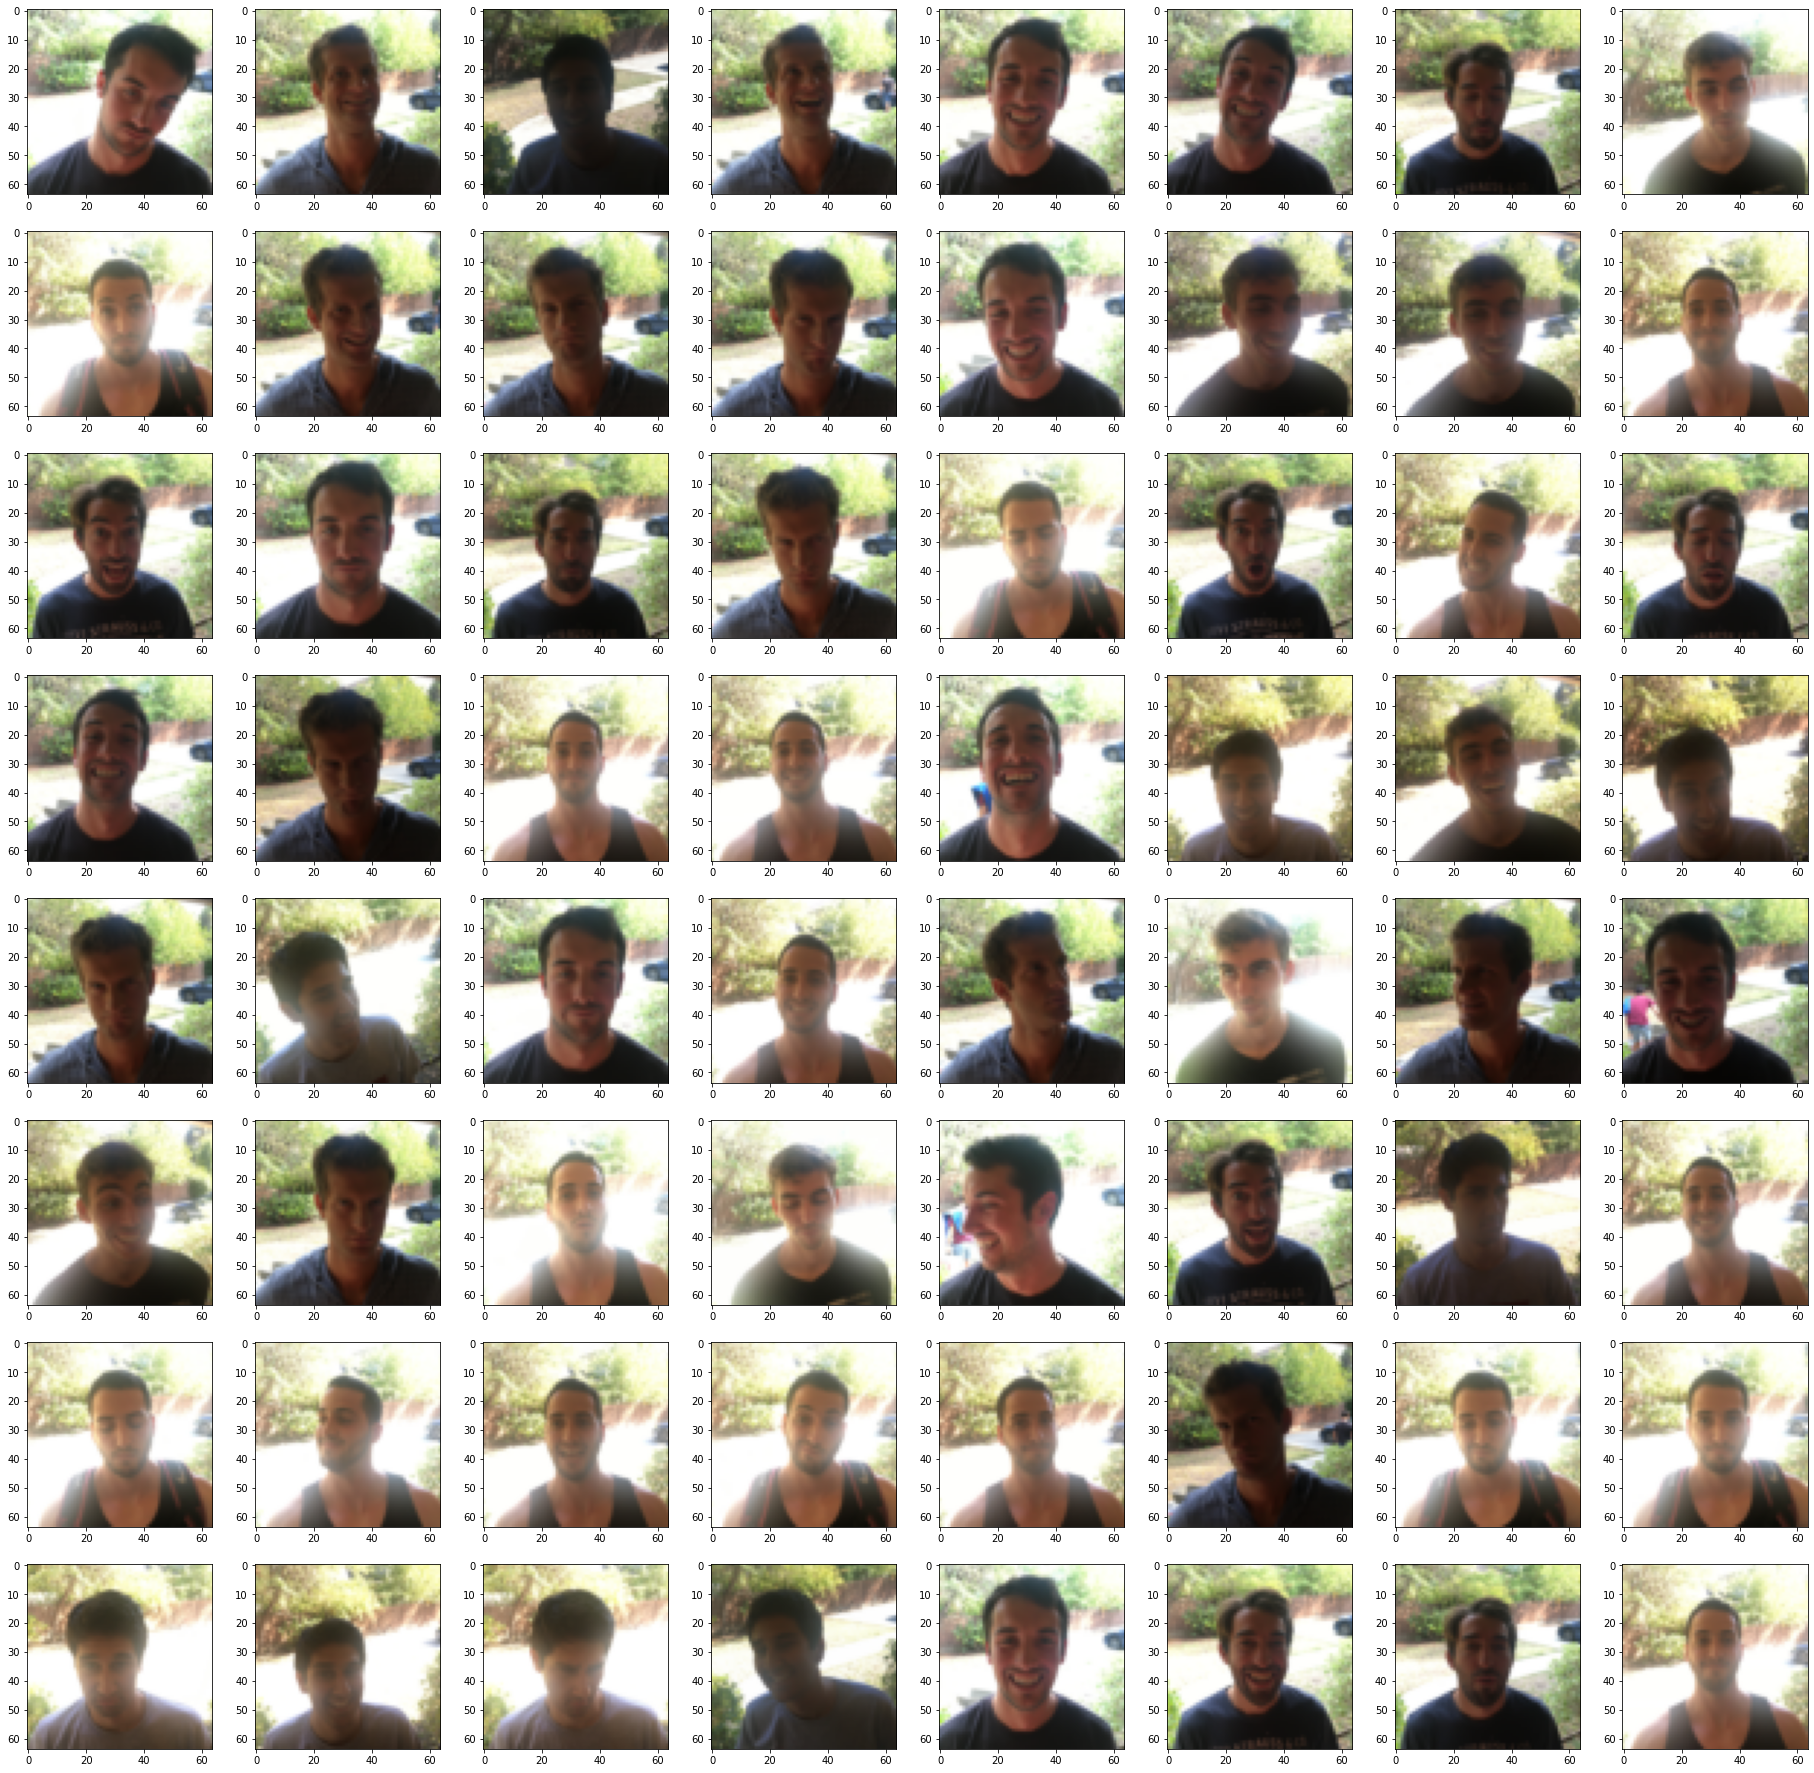

In [ ]:
numrows = 8
numcols = 8
pictureindex = 0

fig = plt.gcf()
fig.set_size_inches(numcols * 4, numrows * 4)

pictureindex += 64

first_picture = [image_ for image_ in processed_data_set[0][pictureindex-64: pictureindex]]


for i, image in enumerate(first_picture):

  subplot = plt.subplot(numrows, numcols, i+1)
  plt.imshow(image)

plt.show()

In [ ]:
trainingdatax, trainingdatay, testingdatax, testingdatay = processed_data_set

In [ ]:
def image_data_as_array(training_data, testing_data):
  training_image_array = []
  test_image_array = []
  for train_array in training_data:
    traingrayimage = cv2.cvtColor(train_array, cv2.COLOR_RGB2GRAY)
    training_image_array.append(traingrayimage)

  training_image_array = np.array(training_image_array)

  for test_image in testing_data:
    testgrayimage = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)
    test_image_array.append(testgrayimage)

  test_image_array = np.array(test_image_array)

  return training_image_array, test_image_array

In [ ]:
array_data = image_data_as_array(processed_data_set[0], processed_data_set[2])

In [ ]:
x_axis_training_data = array_data[0]
y_axis_training_data = processed_data_set[1]
x_axis_test_data = array_data[1]
y_axis_test_data = processed_data_set[3]

print(x_axis_training_data.shape, y_axis_training_data.shape)
print(x_axis_test_data.shape , y_axis_test_data.shape)

(600, 64, 64) (1, 600)
(150, 64, 64) (1, 150)


plotting what the images look like here

In [ ]:
x_axis_training_data = x_axis_training_data.reshape((-1, 64, 64, 1))
x_axis_test_data = x_axis_test_data.reshape((-1, 64, 64, 1))


In [ ]:
print(y_axis_training_data.shape)

y_axis_training_data = np.moveaxis(y_axis_training_data, -1, 0)


(1, 600)


In [ ]:
print(y_axis_training_data.shape)

(600, 1)


In [ ]:
print(x_axis_training_data.shape, y_axis_training_data.shape)

print(type(x_axis_training_data), type(x_axis_test_data))
print(type(y_axis_test_data), type(y_axis_training_data))

(600, 64, 64, 1) (600, 1)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [ ]:
y_axis_test_data = np.moveaxis(y_axis_test_data, -1, 0)
print(y_axis_test_data.shape)

(150, 1)


In [ ]:
training_datagen = ImageDataGenerator(
                    samplewise_center=True,
                    samplewise_std_normalization=True,
                    zoom_range=[0.6, 1.1],
                    rotation_range=20,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    horizontal_flip=True,
                    )

testing_datagen = ImageDataGenerator(
                samplewise_center=True,
                samplewise_std_normalization=True)

training_generator = training_datagen.flow(x_axis_training_data, y_axis_training_data, batch_size=18, shuffle=True)
testing_generator = testing_datagen.flow(x_axis_test_data, y_axis_test_data, batch_size=18, shuffle=False)

In [ ]:
def create_model():

  model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(64,64,1)),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dropout(0.3),
                                    tf.keras.layers.Dense(512, activation='relu'),
                                    tf.keras.layers.Dense(1, activation='sigmoid')
    ])
  return model

In [ ]:
model = create_model()
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 64, 64, 16)        160       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)             

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
model_save_name = 'happy_house_training.pt'
path = F"gdrive/My Drive/final_project/models/happyhousedataset/{model_save_name}"

history = model.fit(training_generator, epochs=50, validation_data=testing_generator, callbacks=[
                                                                                                 tf.keras.callbacks.ModelCheckpoint(path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1),
                                                                                                 tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=8, verbose=1, mode='auto', min_lr=0.001)
])

Epoch 1/50
34/34 [==============================] - 4s 114ms/step - loss: 0.4621 - accuracy: 0.7567 - val_loss: 0.4573 - val_accuracy: 0.7667

Epoch 00001: val_accuracy improved from -inf to 0.76667, saving model to gdrive/My Drive/final_project/models/happyhousedataset/happy_house_training.pt
INFO:tensorflow:Assets written to: gdrive/My Drive/final_project/models/happyhousedataset/happy_house_training.pt/assets
Epoch 2/50
34/34 [==============================] - 4s 116ms/step - loss: 0.4420 - accuracy: 0.7767 - val_loss: 0.3899 - val_accuracy: 0.7800

Epoch 00002: val_accuracy improved from 0.76667 to 0.78000, saving model to gdrive/My Drive/final_project/models/happyhousedataset/happy_house_training.pt
INFO:tensorflow:Assets written to: gdrive/My Drive/final_project/models/happyhousedataset/happy_house_training.pt/assets
Epoch 3/50
34/34 [==============================] - 4s 115ms/step - loss: 0.4734 - accuracy: 0.7533 - val_loss: 0.5473 - val_accuracy: 0.7867

Epoch 00003: val_accur

In [ ]:
def plot_history_data(history_data):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend(loc=0)
  plt.figure()

  plt.plot(epochs, loss, 'ro', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  return plt.show()

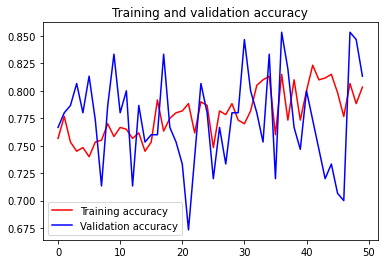

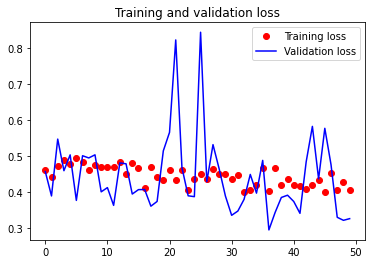

In [ ]:
plot_history_data(history)